In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
from PIL import Image, ImageOps
import io
import skimage as ski
from skimage.filters import threshold_otsu, threshold_local
import scipy.ndimage as ndi
from scipy.signal import convolve
import pywt
import pandas as pd
import os
import matplotlib.cm as cm
from skimage import data
from skimage.util import img_as_ubyte
from skimage.morphology import erosion, dilation, opening, closing, white_tophat  # noqa
from skimage.morphology import black_tophat, skeletonize, convex_hull_image  # noqa
from skimage.morphology import disk  # noqa
from scipy.ndimage import generate_binary_structure, white_tophat

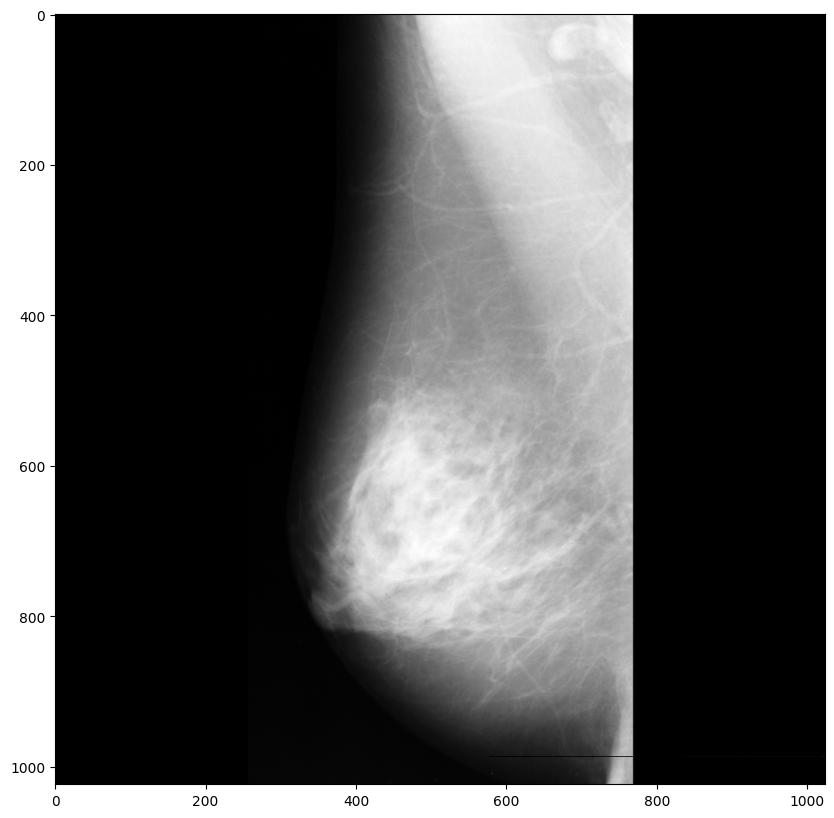

In [245]:
import cv2

# Carregar a imagem corretamente em escala de cinza
img = cv2.imread('dataset/all-mias/mdb211.pgm', cv2.IMREAD_GRAYSCALE)


plt.figure(figsize=(10,10))
plt.imshow(img, cmap='gray')


In [243]:
import matplotlib.pyplot as plt
import numpy as np

def exibir_com_eixo_corrigido(imagem, titulo="Imagem com Eixo Corrigido", cmap='gray'):
    """
    Exibe uma imagem usando Matplotlib, mas com os rótulos do eixo Y
    na orientação cartesiana (0 na base, aumentando para cima), mantendo
    a orientação visual da imagem (linha 0 dos dados no topo).

    Args:
        imagem (np.ndarray): A imagem a ser exibida.
        titulo (str, optional): O título do gráfico.
        cmap (str, optional): O mapa de cores a ser usado (ex: 'gray', 'viridis').
    """
    if imagem is None:
        print("A imagem fornecida é inválida.")
        return

    # 1. Configurar a figura e os eixos
    fig, ax = plt.subplots()

    # 2. Exibir a imagem normalmente. A orientação visual fica correta.
    ax.imshow(imagem, cmap=cmap)

    # 3. Corrigir os rótulos do eixo Y
    altura = imagem.shape[0]
    ticks_atuais = ax.get_yticks()

    # Filtra ticks que possam estar fora dos limites da imagem
    ticks_validos = [tick for tick in ticks_atuais if 0 <= tick < altura]
    
    # Gera novos rótulos invertendo os valores dos ticks válidos
    rotulos_novos = [int(altura - tick) for tick in ticks_validos]

    # Aplica os ticks e os novos rótulos ao eixo
    ax.set_yticks(ticks_validos)
    ax.set_yticklabels(rotulos_novos)

    # 4. Adicionar título e exibir o gráfico
    ax.set_title(titulo)
    plt.show()

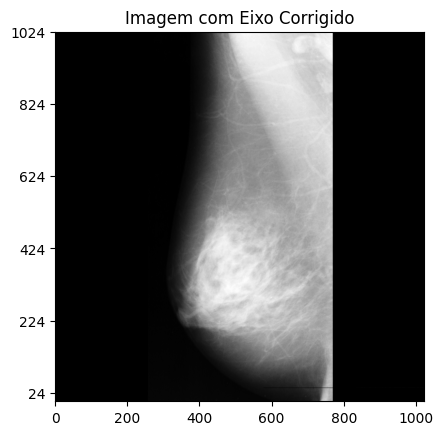

In [244]:
img = exibir_com_eixo_corrigido(img)

In [246]:
import numpy as np
import cv2

def enhance_single_image(image):
    """
    Aplica segmentação e realce morfológico em uma única imagem de mamografia.

    Parâmetros:
        image (np.ndarray): imagem em escala de cinza (grayscale).

    Retorna:
        np.ndarray: imagem realçada (mesma dimensão da região da mama).
    """
    # Limiarização (Otsu)
    _, otsu_threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Fechamento morfológico para segmentação da mama
    kernel = np.ones((3, 3), dtype=np.uint8)
    closing = cv2.morphologyEx(otsu_threshold, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closing, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    if not contours:
        raise ValueError("Nenhum contorno detectado na imagem.")

    # Seleciona o maior contorno como a região da mama
    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    breast_area = image[y:y+h, x:x+w]

    # Realce morfológico usando abertura e fechamento
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 30))
    opening = cv2.morphologyEx(breast_area, cv2.MORPH_OPEN, se)
    closing = cv2.morphologyEx(breast_area, cv2.MORPH_CLOSE, se)

    Fd1 = cv2.subtract(breast_area, opening)
    Fd2 = cv2.subtract(closing, breast_area)

    R = cv2.add(breast_area, Fd1)
    R = cv2.subtract(R, Fd2)

    return R


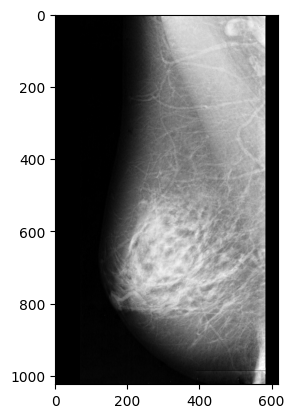

In [264]:
image = enhance_single_image(img)
enhanced_image = image

plt.imshow(image, cmap='gray')

In [265]:
import cv2
import os

def crop_enhanced_image(image, crop_margin=10):
    """
    Corta uma margem da imagem nas bordas e salva opcionalmente o resultado.

    Parâmetros:
        image (np.ndarray): imagem em escala de cinza.
        output_path (str, opcional): caminho completo para salvar a imagem cortada.
        crop_margin (int): pixels a remover de cada lado (default = 10).

    Retorna:
        np.ndarray: imagem cortada.
    """
    height, width = image.shape[:2]

    if height <= 2 * crop_margin or width <= 2 * crop_margin:
        raise ValueError("Imagem muito pequena para o corte especificado.")

    cropped = image[crop_margin:height, crop_margin:width - crop_margin]



    return cropped


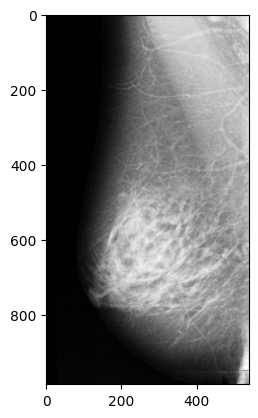

In [266]:
cropped_image = crop_enhanced_image(enhanced_image, crop_margin=40)

plt.imshow(cropped_image, cmap='gray')

In [267]:
import numpy as np
import cv2
import os

def apply_nonlinear_transformation(image, p=7, output_path=None):
    """
    Aplica uma transformação não linear (power-law) a uma imagem em escala de cinza.

    Parâmetros:
        image (np.ndarray): imagem de entrada (grayscale).
        p (float): expoente da transformação (padrão: 5).
        output_path (str, opcional): caminho para salvar a imagem transformada.

    Retorna:
        np.ndarray: imagem transformada.
    """
    # Normaliza para [0, 1]
    normalized_image = image / 255.0

    # Aplica transformação de potência
    transformed_image = np.power(normalized_image, p)

    # Reescala para [0, 255]
    transformed_image = np.clip(transformed_image * 255, 0, 255).astype(np.uint8)

    # Salva se for solicitado
    if output_path:
        output_dir = os.path.dirname(output_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
        cv2.imwrite(output_path, transformed_image)
        print(f"[INFO] Imagem transformada salva em: {output_path}")

    return transformed_image


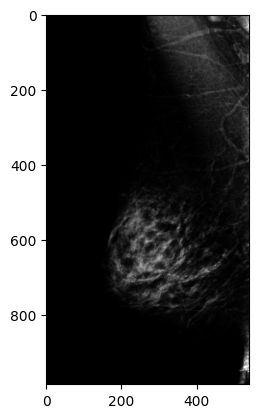

In [268]:
nonlinear_image = apply_nonlinear_transformation(cropped_image)

plt.imshow(nonlinear_image, cmap='gray')

In [269]:
import numpy as np
import cv2
import os

def gaussian_low_pass(img, sigma_r, sigma_c):
    num_rows, num_cols = img.shape
    freq_r = np.fft.fftfreq(num_rows)
    freq_c = np.fft.fftfreq(num_cols)
    freq_r = np.fft.fftshift(freq_r)
    freq_c = np.fft.fftshift(freq_c)    

    freq_r, freq_c = np.meshgrid(freq_r, freq_c, indexing='ij')
    exponent = (freq_r**2 / (2 * sigma_r**2) + freq_c**2 / (2 * sigma_c**2))
    low_pass_gauss_filter = np.exp(-exponent)
    
    return low_pass_gauss_filter

def multiply_alternating(img):
    P, Q = img.shape
    return img * (-1) ** (np.arange(P)[:, None] + np.arange(Q))

def apply_gaussian_low_pass_filter(image, sigma_r=0.05, sigma_c=0.05, output_path=None):
    """
    Aplica um filtro gaussiano de baixa frequência no domínio da frequência (FFT).
    
    Parâmetros:
        image (np.ndarray): imagem em escala de cinza.
        sigma_r (float): desvio padrão na direção das linhas.
        sigma_c (float): desvio padrão na direção das colunas.
        output_path (str, opcional): caminho para salvar a imagem filtrada.

    Retorna:
        np.ndarray: imagem filtrada (recortada ao tamanho original).
    """
    M, N = image.shape

    # Padding
    img_padded = np.pad(image, ((0, M), (0, N)), mode='constant', constant_values=0)
    P, Q = img_padded.shape

    # Centrar espectro
    mult_img = multiply_alternating(img_padded)

    # FFT
    f = np.fft.fft2(mult_img)

    # Filtro
    lp_filter = gaussian_low_pass(img_padded, sigma_r, sigma_c)
    Fimg_filtered = lp_filter * f

    # Volta ao domínio espacial
    img_back = np.fft.ifft2(Fimg_filtered)
    mult_img_back = multiply_alternating(img_back.real)

    # Remover padding
    final_img = mult_img_back[0:M, 0:N].astype(np.uint8)

    # Salvar, se necessário
    if output_path:
        output_dir = os.path.dirname(output_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)
        cv2.imwrite(output_path, final_img)
        print(f"[INFO] Imagem filtrada salva em: {output_path}")

    return final_img


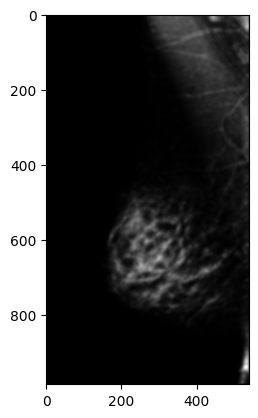

In [270]:
gaussian_filtered_image = apply_gaussian_low_pass_filter(nonlinear_image)

plt.imshow(gaussian_filtered_image, cmap='gray')

In [271]:
import cv2
import numpy as np
import os

def extract_boundary(image, kernel_size=(3, 3)):
    """
    Extrai o contorno de uma imagem usando dilatação menos erosão.

    Parâmetros:
        image (np.ndarray): imagem de entrada (em escala de cinza).
        kernel_size (tuple): tamanho do kernel morfológico (default: (3, 3)).

    Retorna:
        np.ndarray: imagem com o contorno (boundary).
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    dilated = cv2.dilate(image, kernel, iterations=1)
    eroded = cv2.erode(image, kernel, iterations=1)
    boundary = cv2.subtract(dilated, eroded)
    return boundary

def add_boundary_to_image(filtered_image, boundary=None):
    """
    Adiciona o contorno à imagem original e salva os resultados opcionalmente.

    Parâmetros:
        filtered_image (np.ndarray): imagem base filtrada.
        boundary (np.ndarray): contorno extraído (se None, será extraído automaticamente).
        output_filtered_path (str): caminho para salvar imagem com contorno adicionado.
        output_boundary_path (str): caminho para salvar imagem apenas com o contorno.

    Retorna:
        tuple: (imagem com contorno adicionado, imagem de contorno)
    """
    if boundary is None:
        boundary = extract_boundary(filtered_image)

    image_with_boundary = cv2.add(filtered_image, boundary)

   

    return image_with_boundary


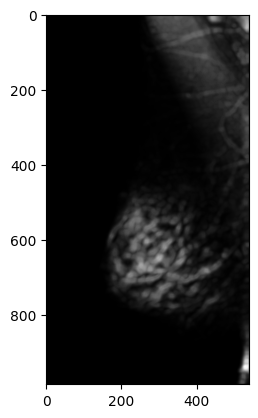

In [272]:
boundary_image = add_boundary_to_image(gaussian_filtered_image)
plt.imshow(boundary_image, cmap='gray')

Imagem de primeiro plano calculada com sucesso!


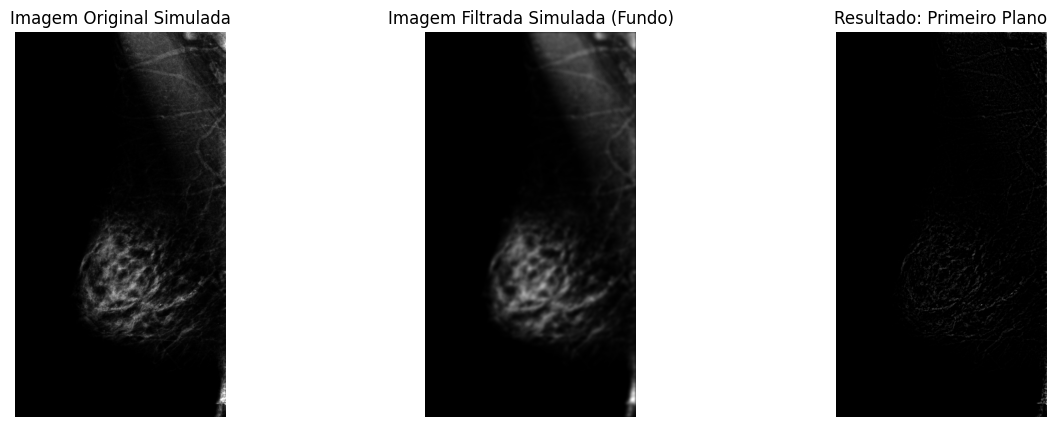

In [273]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def extrair_primeiro_plano(original_image, filtered_image, target_size=(1024, 1024)):
    """
    Isola o primeiro plano de uma imagem subtraindo uma versão filtrada dela.

    Args:
        original_image (np.ndarray): A imagem original (ex: em escala de cinza).
        filtered_image (np.ndarray): A imagem filtrada (ex: com um filtro de suavização).
        target_size (tuple): O tamanho (largura, altura) para o qual as imagens serão
                               redimensionadas antes do processamento.

    Returns:
        np.ndarray: A imagem de primeiro plano resultante (foreground) ou None se
                    as imagens de entrada forem inválidas.
    """
    # 1. Validação da entrada
    if original_image is None or filtered_image is None:
        print("Erro: Uma das imagens de entrada é inválida (None).")
        return None

    # 2. Redimensionamento para garantir compatibilidade
    # Garante que ambas as imagens tenham exatamente as mesmas dimensões.
    #resized_original = cv2.resize(original_image, target_size)
    #resized_filtered = cv2.resize(filtered_image, target_size)

    # 3. Verificação e ajuste do tipo de dados
    # Garante que ambas as imagens tenham o mesmo tipo de dados para a subtração.
    #if resized_original.dtype != resized_filtered.dtype:
     #   resized_filtered = resized_filtered.astype(resized_original.dtype)

    # 4. Cálculo da imagem de primeiro plano (operação principal)
    foreground_image = cv2.subtract(original_image, filtered_image)

    return foreground_image

# 1. Chamar a função refatorada para obter a imagem de primeiro plano
foreground = extrair_primeiro_plano(nonlinear_image, gaussian_filtered_image)

# 2. Verificação do resultado e visualização (opcional)
if foreground is not None:
    print("Imagem de primeiro plano calculada com sucesso!")

    # Mostrar as imagens lado a lado para comparação
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(nonlinear_image, cmap='gray')
    plt.title("Imagem Original Simulada")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gaussian_filtered_image, cmap='gray')
    plt.title("Imagem Filtrada Simulada (Fundo)")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(foreground, cmap='gray')
    plt.title("Resultado: Primeiro Plano")
    plt.axis('off')

    plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

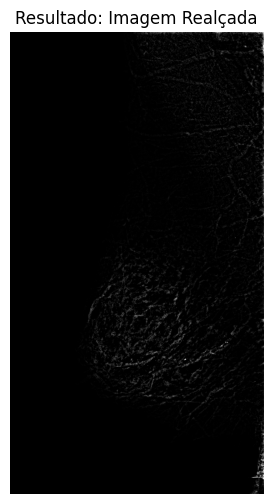

In [274]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def realcar_detalhes_com_tophat(input_image, kernel_size=(15, 15)):
    """
    Realça detalhes brilhantes em uma imagem usando a transformada Top-Hat
    e adicionando o resultado à imagem original.

    A transformada Top-Hat calcula a diferença entre a imagem original e
    sua abertura morfológica, sendo ótima para extrair pequenos elementos.

    Args:
        input_image (np.ndarray): A imagem de entrada (preferencialmente em escala de cinza).
        kernel_size (tuple): O tamanho (largura, altura) do kernel a ser usado
                             na operação morfológica.

    Returns:
        np.ndarray: A imagem com os detalhes realçados, ou None se a
                    imagem de entrada for inválida.
    """
    # 1. Validação da entrada
    if input_image is None:
        print("Erro: A imagem de entrada é inválida (None).")
        return None

    # 2. Definição do kernel (elemento estruturante)
    # O kernel define a "vizinhança" da operação. Detalhes menores que o kernel
    # serão destacados pela transformada Top-Hat.
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

    # 3. Aplicação da Transformada Top-Hat
    # Isso extrai os elementos brilhantes que são menores que o kernel.
    top_hat = cv2.morphologyEx(input_image, cv2.MORPH_TOPHAT, kernel)

    # 4. Adição do resultado à imagem original para realçar os detalhes
    enhanced_image = cv2.add(input_image, top_hat)

    return enhanced_image, top_hat

# 1. Chamar a função refatorada para realçar os detalhes da imagem
enhanced_image, top_hat_image = realcar_detalhes_com_tophat(foreground, kernel_size=(15, 15))

plt.figure(figsize=(18, 6)) # 10 inches wide, 8 inches tall
plt.subplot(1, 3, 1)
plt.imshow(enhanced_image, cmap='gray', vmin=0, vmax=255)
plt.title("Resultado: Imagem Realçada")
plt.axis('off')
plt.show

Contorno extraído e adicionado com sucesso!


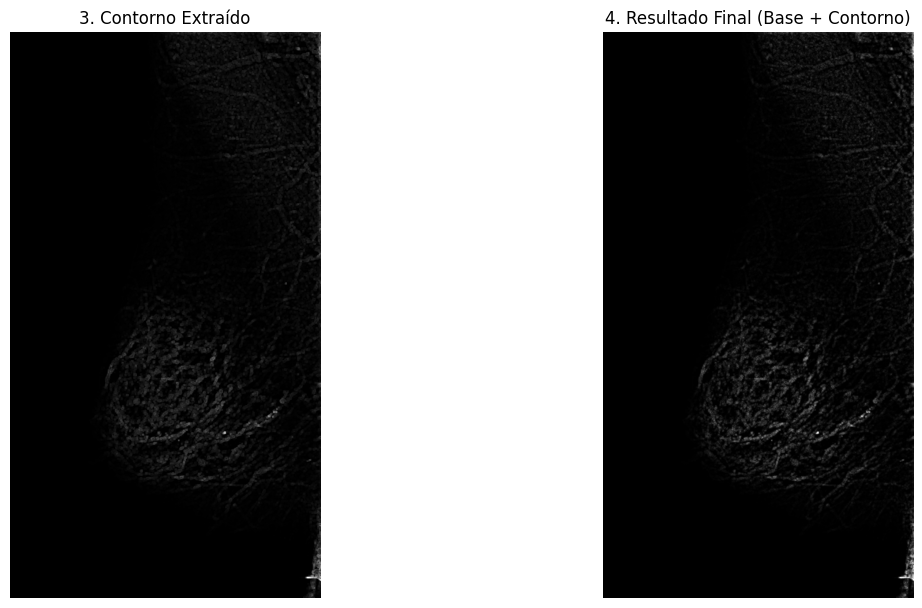

In [275]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def adicionar_contorno_morfologico(base_image, textura_image, kernel_size=(5, 5)):
    """
    Extrai o contorno de uma imagem de textura (usando gradiente morfológico) e o
    adiciona a uma imagem base.

    Esta técnica (diferença entre dilatação e erosão) é conhecida como
    'gradiente morfológico' e é uma maneira eficaz de destacar as bordas ou
    contornos de objetos em uma imagem.

    Args:
        base_image (np.ndarray): A imagem principal à qual o contorno será adicionado
                                 (corresponde a 'foreground_image').
        textura_image (np.ndarray): A imagem da qual o contorno será extraído
                                  (corresponde a 'top_hat_image').
        kernel_size (tuple): O tamanho (largura, altura) do kernel para as
                             operações de dilatação e erosão.

    Returns:
        tuple[np.ndarray, np.ndarray]: Uma tupla contendo:
                                       - A imagem final com o contorno adicionado.
                                       - A imagem do contorno isolado.
                                       Retorna (None, None) se alguma entrada for inválida.
    """
    # 1. Validação da entrada
    if base_image is None or textura_image is None:
        print("Erro: Uma das imagens de entrada é inválida (None).")
        return None, None

    # 2. Definição do kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

    # 3. Cálculo do contorno (Gradiente Morfológico)
    img_dilation = cv2.dilate(textura_image, kernel, iterations=1)
    img_erosion = cv2.erode(textura_image, kernel, iterations=1)
    boundary_image = cv2.subtract(img_dilation, img_erosion)

    # 4. Adição do contorno à imagem de primeiro plano
    final_image = cv2.add(base_image, boundary_image)

    return final_image, boundary_image



# 1. Chamar a função refatorada para obter a imagem final e o contorno
final_result, boundary_result = adicionar_contorno_morfologico(
    foreground,
    top_hat_image,
    kernel_size=(3, 3)
)

# 2. Verificação do resultado e visualização (opcional)
if final_result is not None:
    print("Contorno extraído e adicionado com sucesso!")

    # Mostrar as imagens em um grid 2x2 para entender o processo
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 3)
    plt.imshow(boundary_result, cmap='gray')
    plt.title("3. Contorno Extraído")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(final_result, cmap='gray')
    plt.title("4. Resultado Final (Base + Contorno)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Filtro bilateral aplicado com sucesso!


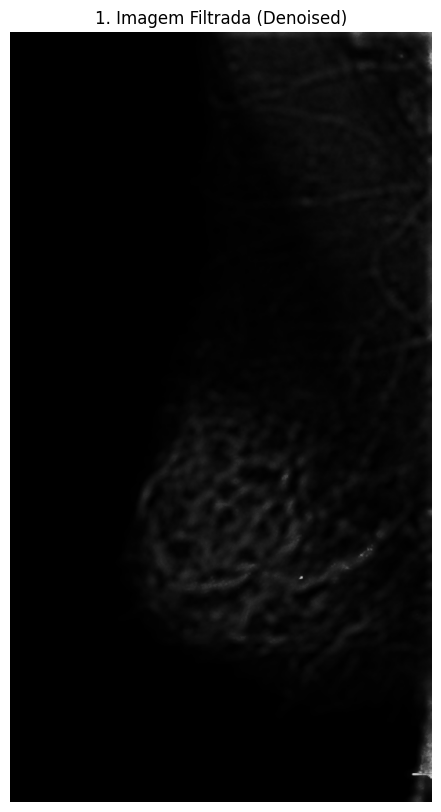

In [276]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def reduzir_ruido_bilateral(input_image, d=15, sigma_color=75, sigma_space=75):
    """
    Aplica um filtro bilateral a uma imagem para reduzir o ruído preservando as bordas.

    O filtro bilateral é altamente eficaz na remoção de ruído, pois considera tanto a
    proximidade espacial dos pixels quanto a similaridade de suas intensidades (cores).

    Args:
        input_image (np.ndarray): A imagem de entrada.
        d (int): Diâmetro da vizinhança de cada pixel.
        sigma_color (int): Desvio padrão do filtro no espaço de cores. Um valor
                           maior significa que cores mais distantes serão misturadas.
        sigma_space (int): Desvio padrão do filtro no espaço de coordenadas. Um
                           valor maior significa que pixels mais distantes influenciarão
                           uns aos outros.

    Returns:
        np.ndarray: A imagem com ruído reduzido, ou None se a entrada for inválida.
    """
    # 1. Validação da entrada
    if input_image is None:
        print("Erro: A imagem de entrada é inválida (None).")
        return None

    # 2. Aplicação do filtro bilateral
    # A função opera diretamente em imagens uint8, preservando o tipo de dado.
    denoised_image = cv2.bilateralFilter(input_image, d, sigma_color, sigma_space)

    return denoised_image


denoised_image = reduzir_ruido_bilateral(final_result)

# 4. Verificação e visualização dos resultados
if denoised_image is not None:
    print("Filtro bilateral aplicado com sucesso!")

    plt.figure(figsize=(10,10))
    plt.subplot(1, 1, 1)
    plt.imshow(denoised_image, cmap='gray', vmin=0, vmax=255)
    plt.title("1. Imagem Filtrada (Denoised)")
    plt.axis('off')

    plt.show()

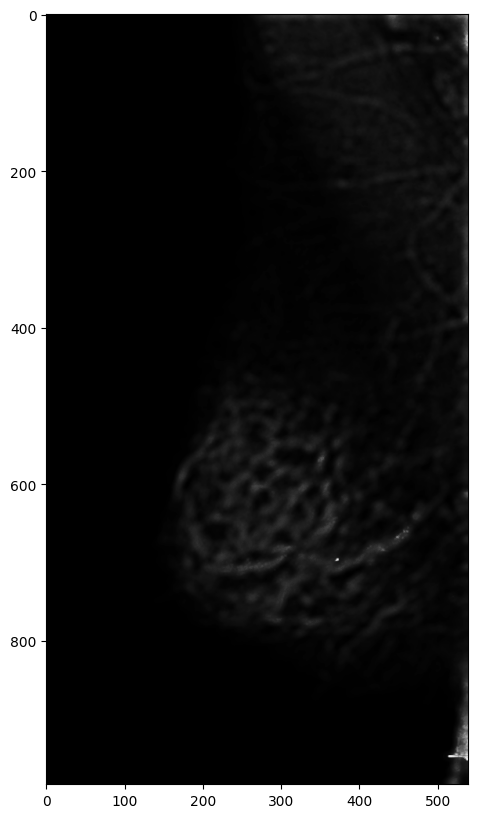

In [277]:
normalized_image = cv2.normalize(denoised_image, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

plt.figure(figsize=(10,10))
plt.imshow(normalized_image, cmap='gray')

Filtro LoG aplicado com sucesso! EDGE


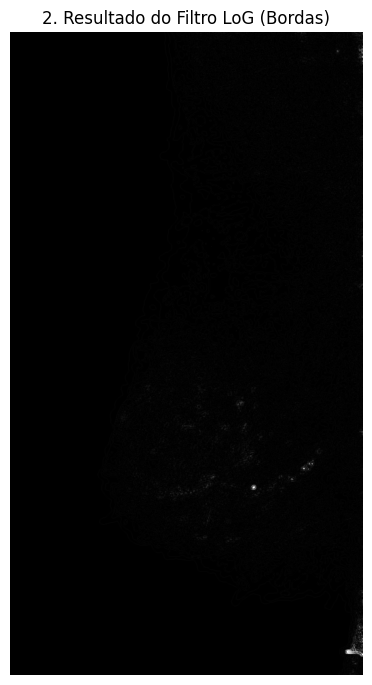

In [278]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def aplicar_filtro_log(input_image, blur_ksize=(3, 3), laplacian_ksize=3):
    """
    Aplica um filtro Laplaciano de Gaussiana (LoG) para detecção de bordas.

    O processo consiste em duas etapas:
    1. Suavizar a imagem com um filtro Gaussiano para reduzir ruído.
    2. Aplicar um filtro Laplaciano para detectar áreas de rápida mudança de
       intensidade (bordas).

    Args:
        input_image (np.ndarray): A imagem de entrada.
        blur_ksize (tuple): O tamanho do kernel para o filtro Gaussiano.
        laplacian_ksize (int): O tamanho do kernel para o filtro Laplaciano.

    Returns:
        np.ndarray: A imagem com as bordas detectadas, ou None se a entrada
                    for inválida.
    """
    # 1. Validação da entrada
    if input_image is None:
        print("Erro: A imagem de entrada é inválida (None).")
        return None

    # 2. Garantir que a imagem está em escala de cinza
    if len(input_image.shape) == 3:
        image_gray = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    else:
        image_gray = input_image

    # 3. Aplicar o filtro Gaussiano para suavização
    blurred = cv2.GaussianBlur(image_gray, blur_ksize, 0)

    # 4. Aplicar o filtro Laplaciano
    # Usamos cv2.CV_16S para evitar perda de dados, pois o Laplaciano pode
    # gerar valores negativos nas bordas.
    laplacian = cv2.Laplacian(blurred, cv2.CV_16S, ksize=laplacian_ksize)

    # 5. Converter de volta para uint8, pegando o valor absoluto das bordas
    # Esta etapa é crucial para a visualização e salvamento corretos.
    log_image = cv2.convertScaleAbs(laplacian)

    return log_image

# 1. Chamar a função refatorada para aplicar o filtro LoG
log_result = aplicar_filtro_log(normalized_image, blur_ksize=(3, 3), laplacian_ksize=3)


# 2. Verificação e visualização dos resultados
if log_result is not None:
    print("Filtro LoG aplicado com sucesso! EDGE")


    plt.figure(figsize=(10,10))
    plt.subplot(1, 2, 2)
    plt.imshow(log_result, cmap='gray')
    plt.title("2. Resultado do Filtro LoG (Bordas)")
    plt.axis('off')

    plt.show()

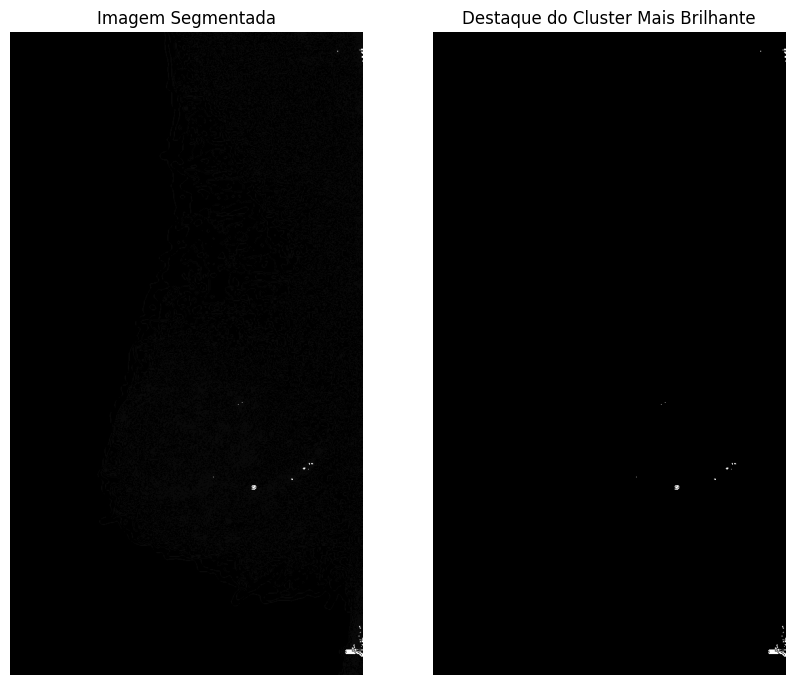

In [279]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def segmentar_com_kmeans(input_image, k=2, destacar_mais_brilhante=False):
    """
    Segmenta uma imagem usando K-means de forma flexível.

    Por padrão, apenas segmenta a imagem em 'k' níveis de cinza.
    Se 'destacar_mais_brilhante' for True, ela também identifica e retorna
    uma máscara do cluster com a maior intensidade média.

    Args:
        input_image (np.ndarray): A imagem de entrada em escala de cinza.
        k (int): O número de clusters a serem encontrados.
        destacar_mais_brilhante (bool): Se True, ativa a funcionalidade extra
            para isolar o cluster mais brilhante.

    Returns:
        np.ndarray or tuple[np.ndarray, np.ndarray]:
            - Se 'destacar_mais_brilhante' for False, retorna apenas a imagem segmentada.
            - Se 'destacar_mais_brilhante' for True, retorna uma tupla contendo
              (máscara_brilhante, imagem_segmentada).
            - Retorna None em caso de erro.
    """
    # --- Etapa 1: Lógica Principal do K-means (comum a ambos os casos) ---
    if input_image is None:
        print("Erro: A imagem de entrada é inválida (None).")
        return None

    pixel_values = input_image.reshape((-1, 1))
    pixel_values = np.float32(pixel_values)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(input_image.shape)

    
    # Comportamento avançado: encontra o cluster mais brilhante e o retorna também
    brightest_cluster_index = np.argmax(centers)
    labels_reshaped = labels.reshape(input_image.shape)
    highlighted_image = np.where(labels_reshaped == brightest_cluster_index, 255, 0).astype(np.uint8)

    return highlighted_image, segmented_image


# Note que agora esperamos duas imagens de retorno
mascara, img_segmentada = segmentar_com_kmeans(log_result, k=3, destacar_mais_brilhante=True)

if mascara is not None:

    plt.figure(figsize=(10,10))

    plt.subplot(1, 2, 1)
    plt.imshow(img_segmentada, cmap='gray')
    plt.title("Imagem Segmentada")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mascara, cmap='gray')
    plt.title("Destaque do Cluster Mais Brilhante")
    plt.axis('off')
    plt.show()